# ROI‑Supervised Deep Learning for HER2 Breast Cancer Classification

## Abstract
We present a reproducible, multi‑phase deep learning pipeline for HER2 breast cancer classification that trains on expert‑annotated regions of interest (ROIs) from whole‑slide images. Phase 1 performs ROI‑supervised classification with a ResNet‑50 backbone; Phase 2 applies multiple instance learning (MIL) to refine slide‑level predictions; Phase 3 trains a segmentation model using ROI‑derived masks. The pipeline includes native H&E stain normalization, elastic deformation and color augmentation, and integrated Grad‑CAM for interpretability. Experiment tracking captures hyperparameters, metrics, confusion matrices, and model artifacts to support reproducibility and auditability. This notebook provides end‑to‑end code, configuration, and documentation suitable for research and clinical validation studies.

Keywords: HER2, digital pathology, region‑of‑interest supervision, multiple instance learning, stain normalization, Grad‑CAM, reproducibility

## Methods overview
- Phase 1 — ROI‑supervised classification: ResNet‑50 backbone; patch extraction strictly within annotated ROIs; wandb metrics and artifacts.
- Phase 2 — MIL fine‑tuning: attention‑based MIL initialized from Phase 1; bag‑level training; attention/Grad‑CAM visualizations.
- Phase 3 — ROI‑derived segmentation: U‑Net with ResNet backbone; ROI polygons converted to masks; Dice/IoU and pixel accuracy.

## Reproducible setup and execution
- Prerequisites: Python 3.8+, PyTorch (CUDA‑enabled if available), GPU ≥8 GB VRAM recommended, 16–32 GB RAM, SVS slides with XML annotations.
- Execution protocol: restart kernel, run cells sequentially, verify data paths and CUDA availability in config, wandb logging is enabled by default.
- Expected outputs: model checkpoints and configs, wandb runs with metrics/artifacts, Grad‑CAM overlays, summary tables/figures.

## Experiment tracking (wandb)
- Metrics: loss (train/val), LR, early‑stopping; accuracy, precision/recall/F1, ROC‑AUC; confusion matrix; segmentation Dice/IoU.
- Artifacts and lineage: versioned checkpoints (by phase/fold), exported configs, selected overlays; dataset fingerprints and code version when available.
- Multi‑phase consistency: links Phase 1→2→3 to analyze feature transfer and ROI utilization; includes attention weights and Grad‑CAM when generated.

## Notes
- Data privacy/IRB compliance is required for clinical datasets.
- Seeds are fixed where supported; minor nondeterminism can remain on CUDA/cuDNN.
- Report hardware specifications and preserve artifacts to facilitate replication.

In [9]:
"""
Environment setup and dependencies
==================================

Configures the runtime environment and imports required libraries for the HER2 classification pipeline.
"""

import os
import sys
import warnings
from pathlib import Path

# Environment configuration for stable, reproducible runs
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'  # OpenMP compatibility
os.environ['OMP_NUM_THREADS'] = '1'          # Threading optimization
warnings.filterwarnings('ignore')             # Suppress non-critical warnings

# Python 3.13 compatibility shim
import collections
import collections.abc
if not hasattr(collections, 'Callable'):
    collections.Callable = collections.abc.Callable

# Core scientific computing libraries
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from IPython.display import clear_output, display

# Jupyter notebook configuration
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Configure matplotlib for publication-quality figures
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 10

# Add project root to Python path
sys.path.append('.')

# Import pipeline modules
from scripts.train import (Config, train_phase1, train_phase2, train_segmentation, 
                          explain_predictions, optimize_hyperparameters)
from scripts.augmentations import (get_classification_transforms, get_segmentation_transforms, 
                                 AugmentationConfig)
from scripts.config import create_default_config, create_quick_test_config, create_production_config

# Verify CUDA availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    print(f"CUDA available: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
else:
    print("CUDA not available - using CPU")

PyTorch Grad-CAM not available. Install with: pip install pytorch-grad-cam

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
CUDA available: NVIDIA GeForce RTX 4060 Laptop GPU
Memory: 8.6 GB
CUDA available: NVIDIA GeForce RTX 4060 Laptop GPU
Memory: 8.6 GB


In [10]:
"""
Memory Management and Kernel Cleanup
====================================

Ensures clean execution environment by clearing previous variables and optimizing memory usage.
This is particularly important for reproducible results in deep learning experiments.
"""

import gc

# Print messages only once per kernel session
SENTINEL = "_CLEANUP_MESSAGES_PRINTED"
first_time = not globals().get(SENTINEL, False)

is_torch = 'torch' in globals()
is_gpu = is_torch and hasattr(globals()['torch'], 'cuda') and globals()['torch'].cuda.is_available() if is_torch else False

if first_time:
    print("Cleaning up environment")

# Clear potential variables from previous runs
cleanup_variables = [
    'att_weights', 'attention_weights', 'cam', 'grayscale_cam', 
    'img_mil', 'img_tensor', 'model', 'outputs', 'predicted',
    'target_layer', 'target_layers', 'test_image', 'wrapper_model'
]

cleaned_count = 0
for var_name in cleanup_variables:
    if var_name in globals():
        del globals()[var_name]
        cleaned_count += 1

# Force garbage collection
gc.collect()

# Clear GPU memory cache if available (always execute, only print once)
if is_gpu:
    globals()['torch'].cuda.empty_cache()

if first_time:
    if is_gpu:
        gpu_memory = globals()['torch'].cuda.get_device_properties(0).total_memory / 1e9
        print(f"✅ GPU memory cache cleared ({gpu_memory:.1f} GB available)")
    else:
        print("No GPU available or torch not imported; skipping GPU cache clear.")
    
    print(f"Environment initialized successfully")
    print(f"   Variables cleaned: {cleaned_count}")
    print(f"   Memory optimization: Complete")
    print("Ready for reproducible experiment execution")
    
    # Set sentinel so subsequent runs are silent
    globals()[SENTINEL] = True

In [12]:
"""
Pipeline Configuration
=====================

Configures training parameters and system settings for the HER2+ classification pipeline.
Three configuration profiles are available:
- 'quick_test': Rapid prototyping (5 epochs, reduced parameters)
- 'default': Standard research settings (50 epochs, balanced parameters)  
- 'production': Publication-quality training (200 epochs, full parameters)
"""

print("⚙️ Configuring HER2+ Classification Pipeline")
print("=" * 50)

# Select configuration profile
# Options: "quick_test", "default", "production"
CONFIG_PROFILE = "production"  # Change this for different experimental setups

# Initialize configuration based on profile
config_mapping = {
    "quick_test": (create_quick_test_config, "Quick Test - Rapid Prototyping"),
    "default": (create_default_config, "Default - Research Settings"),
    "production": (create_production_config, "Production - Publication Quality")
}

if CONFIG_PROFILE in config_mapping:
    config_func, description = config_mapping[CONFIG_PROFILE]
    config = config_func()
    print(f"📋 Configuration: {description}")
else:
    config = create_default_config()
    print(f"⚠️ Unknown profile '{CONFIG_PROFILE}', using default configuration")

# Override paths for current environment
config.data.data_dir = "data"
config.data.annotations_dir = "Annotations"
config.data.output_dir = "output"
config.data.checkpoints_dir = "checkpoints"

# Optimize for notebook execution
config.training.num_workers = 0  # Windows compatibility
config.training.device = "cuda" if torch.cuda.is_available() else "cpu"

# Use batch size 1 to fit 1024 patches at level 0
config.model.batch_size = 1

# Display configuration summary
print(f"\n📊 Training Configuration Summary:")
print(f"   Device: {config.training.device}")
print(f"   Batch Size: {config.model.batch_size}")
print(f"   Epochs: {config.model.num_epochs}")
print(f"   Learning Rate: {config.model.learning_rate}")
print(f"   Model Backbone: ResNet-50")
print(f"   Training Strategy: ROI-Supervised → MIL → Segmentation")

# Initialize directory structure
config.data.__post_init__()

print("\n✅ Pipeline configuration complete")
print(f"📁 Output directories: {config.data.output_dir}")
print(f"💾 Model checkpoints: {config.data.checkpoints_dir}")

⚙️ Configuring HER2+ Classification Pipeline
📋 Configuration: Production - Publication Quality
📋 Configuration: Production - Publication Quality

📊 Training Configuration Summary:
   Device: cuda

📊 Training Configuration Summary:
   Device: cuda
   Batch Size: 1
   Epochs: 15
   Learning Rate: 0.0001
   Model Backbone: ResNet-50

   Batch Size: 1
   Epochs: 15
   Learning Rate: 0.0001
   Model Backbone: ResNet-50
   Training Strategy: ROI-Supervised → MIL → Segmentation

✅ Pipeline configuration complete
📁 Output directories: output
   Training Strategy: ROI-Supervised → MIL → Segmentation

✅ Pipeline configuration complete
📁 Output directories: output
💾 Model checkpoints: checkpoints
💾 Model checkpoints: checkpoints


In [13]:
"""
Dataset metadata generation
===========================

Creates a CSV linking SVS whole-slide images with XML annotations. Enables ROI-supervised training by mapping pathologist annotations to slides.
"""

print("Generating dataset metadata")
print("=" * 32)

# Define data paths
data_dir = Path("data")
svs_dir = data_dir / "SVS"
annotations_dir = data_dir / Path("Annotations")
metadata_file = data_dir / "metadata.csv"

print(f"Data directory: {data_dir}")
print(f"SVS files: {svs_dir}")
print(f"Annotations: {annotations_dir}")

# Validate directory structure
if not svs_dir.exists():
    print(f"Warning: SVS directory not found at {svs_dir}")
if not annotations_dir.exists():
    print(f"Warning: Annotations directory not found at {annotations_dir}")

# Collect slide information
slides_data = []
her2_neg_count = 0
her2_pos_count = 0
annotated_count = 0

# Process all SVS files
svs_files = list(svs_dir.glob("*.svs")) if svs_dir.exists() else []
print(f"\nProcessing {len(svs_files)} SVS files...")

for svs_file in svs_files:
    slide_name = svs_file.stem
    
    # Extract HER2 status from filename
    if slide_name.startswith("Her2Neg"):
        her2_status = 0
        label = "HER2-"
        her2_neg_count += 1
    elif slide_name.startswith("Her2Pos"):
        her2_status = 1
        label = "HER2+"
        her2_pos_count += 1
    else:
        print(f"Unrecognized slide naming: {slide_name}")
        continue
    
    # Check for corresponding annotation
    annotation_file = annotations_dir / f"{slide_name}.xml"
    has_annotation = annotation_file.exists()
    if has_annotation:
        annotated_count += 1
    
    slide_info = {
        'slide_name': slide_name,
        'slide_path': str(svs_file),
        'her2_status': her2_status,
        'label': label,
        'has_annotation': has_annotation,
        'annotation_path': str(annotation_file) if has_annotation else None
    }
    slides_data.append(slide_info)

# Create structured DataFrame
df = pd.DataFrame(slides_data)
df = df.sort_values('slide_name').reset_index(drop=True)

# Save metadata
df.to_csv(metadata_file, index=False)

# Display dataset statistics
print(f"\nDataset statistics:")
print(f"  Total slides: {len(df)}")
print(f"  HER2- cases: {her2_neg_count}")
print(f"  HER2+ cases: {her2_pos_count}")
print(f"  Annotated slides: {annotated_count}")
print(f"  Annotation coverage: {(annotated_count/len(df)*100):.1f}%" if len(df) > 0 else "  Annotation coverage: 0%")

# Display sample data
if len(df) > 0:
    print(f"\nSample metadata (first 3 rows):")
    print(df[['slide_name', 'label', 'has_annotation']].head(3).to_string(index=False))

# Annotation distribution analysis
if annotated_count > 0:
    annotated_df = df[df['has_annotation'] == True]
    roi_neg = len(annotated_df[annotated_df['her2_status'] == 0])
    roi_pos = len(annotated_df[annotated_df['her2_status'] == 1])
    
    print(f"\nROI annotation distribution:")
    print(f"  HER2- with ROIs: {roi_neg}")
    print(f"  HER2+ with ROIs: {roi_pos}")
    print(f"  Class balance: {(roi_pos/(roi_neg+roi_pos)*100):.1f}% HER2+" if (roi_neg+roi_pos) > 0 else "  Class balance: No data")

print(f"\nMetadata saved: {metadata_file}")
print("Dataset preparation complete")

Generating dataset metadata
Data directory: data

Data directory: data
SVS files: data\SVS
Annotations: data\Annotations
SVS files: data\SVS
Annotations: data\Annotations

Processing 192 SVS files...

Processing 192 SVS files...

Dataset statistics:
  Total slides: 192
  HER2- cases: 99
  HER2+ cases: 93
Dataset statistics:
  Total slides: 192
  HER2- cases: 99
  HER2+ cases: 93
  Annotated slides: 187

  Annotated slides: 187
  Annotation coverage: 97.4%

Sample metadata (first 3 rows):  Annotation coverage: 97.4%

Sample metadata (first 3 rows):

     slide_name label  has_annotation
Her2Neg_Case_01 HER2-            True
Her2Neg_Case_02 HER2-            True
Her2Neg_Case_03 HER2-            True

ROI annotation distribution:     slide_name label  has_annotation
Her2Neg_Case_01 HER2-            True
Her2Neg_Case_02 HER2-            True
Her2Neg_Case_03 HER2-            True

ROI annotation distribution:
  HER2- with ROIs: 97
  HER2- with ROIs: 97
  HER2+ with ROIs: 90
  Class balance:

In [ ]:
"""
Phase 1: ROI-supervised classification training
==============================================

Trains a ResNet-50–based classifier exclusively on expert-annotated ROIs. Establishes features for subsequent MIL and segmentation phases.
"""

print("Phase 1: ROI-supervised classification")
print("=" * 42)

from pathlib import Path
import pandas as pd

# Initialize legacy configuration for backward compatibility
from scripts.train import Config as LegacyConfig

legacy_config = LegacyConfig()
legacy_config.DATA_DIR = Path(config.data.data_dir)
legacy_config.ANNOTATIONS_DIR = Path(config.data.annotations_dir)
legacy_config.CHECKPOINT_DIR = Path(config.data.checkpoints_dir)
legacy_config.LOG_DIR = Path(config.data.output_dir) / "logs"
# High-res settings like last time
legacy_config.BATCH_SIZE = 1  # keep VRAM safe while preserving resolution
legacy_config.EPOCHS_PHASE1 = config.model.num_epochs
legacy_config.LR_PHASE1 = config.model.learning_rate
legacy_config.NUM_WORKERS = config.training.num_workers
legacy_config.DEVICE = torch.device(config.training.device)

# Preserve high-resolution method; avoid input downscaling and freezing
legacy_config.INPUT_SIZE = None            # do not rescale inputs
legacy_config.LOW_MEM_MODE = False         # keep backbone trainable
legacy_config.GRADIENT_CHECKPOINT = True   # save GPU memory without reducing resolution

# Use large patch at highest resolution
legacy_config.PATCH_SIZE = 1024                 # restore 1024
legacy_config.PATCHES_PER_SLIDE_PHASE1 = 1000   # restore high sampling
legacy_config.SLIDE_READ_LEVEL = 0              # highest resolution

# Initialize directory structure
legacy_config.__post_init__()

# Validate ROI annotation availability
metadata_file = legacy_config.DATA_DIR / "metadata.csv"
roi_validation_passed = False

if metadata_file.exists():
    df = pd.read_csv(metadata_file)
    roi_slides = df[df['has_annotation'] == True]
    total_slides = len(df)
    roi_count = len(roi_slides)
    
    print("ROI validation results:")
    print(f"  Total slides: {total_slides}")
    print(f"  ROI annotated: {roi_count}")
    print(f"  Coverage: {(roi_count/total_slides*100):.1f}%")
    
    if roi_count > 0:
        her2_neg_roi = len(roi_slides[roi_slides['her2_status'] == 0])
        her2_pos_roi = len(roi_slides[roi_slides['her2_status'] == 1])
        print(f"  HER2- with ROIs: {her2_neg_roi}")
        print(f"  HER2+ with ROIs: {her2_pos_roi}")
        roi_validation_passed = True
        print("Annotations validated — proceeding with supervised training")
    else:
        print("No ROI annotations found — training will use random sampling")
else:
    print("Metadata file not found — run data preparation first")

# Display training configuration
print(f"\nTraining configuration:")
print(f"  Architecture: AttentionMIL with ResNet-50 backbone")
print(f"  Strategy: ROI-supervised patch extraction")
print(f"  Patch size: {legacy_config.PATCH_SIZE}×{legacy_config.PATCH_SIZE} pixels (level {getattr(legacy_config, 'SLIDE_READ_LEVEL', 0)})")
print(f"  Patches per slide: {legacy_config.PATCHES_PER_SLIDE_PHASE1}")
print(f"  Batch size: {legacy_config.BATCH_SIZE}")
print(f"  Epochs: {legacy_config.EPOCHS_PHASE1}")
print(f"  Learning rate: {legacy_config.LR_PHASE1}")
print(f"  Device: {legacy_config.DEVICE}")
print(f"  Grad checkpoint: {getattr(legacy_config, 'GRADIENT_CHECKPOINT', False)}")
print(f"  Augmentation: Elastic deformation ({legacy_config.ELASTIC_DEFORM_PROB*100}%)")
print(f"  Stain variation: H&E augmentation ({legacy_config.STAIN_AUGMENT_PROB*100}%)")

# Execute training
try:
    print("\nStarting ROI-supervised training…")
    
    # Run Phase 1 training (streamlined without TensorBoard)
    train_phase1(legacy_config, fold=0, writer=None)
    
    print("Training completed successfully.")
    
    # Generate model interpretability visualizations
    phase1_model_path = legacy_config.CHECKPOINT_DIR / "phase1_fold0_best.pth"
    if phase1_model_path.exists():
        print("\nGenerating model interpretability visualizations…")
        explain_predictions(legacy_config, str(phase1_model_path), fold=0, num_samples=3)
        print("Grad-CAM explanations generated.")
        print(f"Visualizations saved to: {legacy_config.LOG_DIR / 'explanations'}")
    
except KeyboardInterrupt:
    print("Training interrupted by user.")
except Exception as e:
    print(f"Training failed: {e}")
    print("Check data paths and GPU availability.")
    import traceback
    traceback.print_exc()
finally:
    print(f"\nSession complete.")
    print(f"Checkpoints: {legacy_config.CHECKPOINT_DIR}")
    print(f"Logs: {legacy_config.LOG_DIR}")

Phase 1: ROI-supervised classification

ROI validation results:
  Total slides: 192
  ROI annotated: 187
  Coverage: 97.4%
ROI validation results:
  Total slides: 192
  ROI annotated: 187
  Coverage: 97.4%
  HER2- with ROIs: 97
  HER2+ with ROIs: 90
Annotations validated — proceeding with supervised training
  HER2- with ROIs: 97
  HER2+ with ROIs: 90
Annotations validated — proceeding with supervised training

Training configuration:
  Architecture: AttentionMIL with ResNet-50 backbone
  Strategy: ROI-supervised patch extraction
  Patch size: 1024×1024 pixels (level 0)

Training configuration:
  Architecture: AttentionMIL with ResNet-50 backbone
  Strategy: ROI-supervised patch extraction
  Patch size: 1024×1024 pixels (level 0)
  Patches per slide: 1000
  Batch size: 1
  Epochs: 15
  Learning rate: 0.0001  Patches per slide: 1000
  Batch size: 1
  Epochs: 15
  Learning rate: 0.0001
  Device: cuda
  Grad checkpoint: True
  Augmentation: Elastic deformation (30.0%)
  Stain variation: H

batch/accuracy,▁▁██▁█▁██▁▁███▁█▁█▁▁█▁█▁██▁█▁███▁█▁▁▁▁█▁
batch/epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,▂▂▂▂▃▇▄▂▂▂▄▃▃▃▂▅▅▁▁▁██▅▄▁▆▅▁▁▁▁▇▂▁▄▅▅▂▅▅
batch/samples_processed,▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
batch/step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇█
model/model_size_mb,▁
model/total_parameters,▁
model/trainable_parameters,▁
batch/accuracy,0
batch/epoch,0


Train E1:   0%|          | 0/153000 [00:00<?, ?it/s]

In [ ]:
# Weights & Biases: links and monitored signals (concise)
print("Weights & Biases: ROI-supervised training runs")
print("=" * 48)

# Replace with your project URL if different
print("Project: https://wandb.ai/thanakornbua/her2-breast-cancer")
print("Runs (illustrative):")
print("  • Phase 1 (ROI classification): Phase1_ROI_Supervised_fold0")
print("  • Phase 2 (MIL): Phase2_MIL_FineTuning_fold0")
print("  • Phase 3 (Segmentation): Phase3_Segmentation_fold0")

print("\nMonitored signals:")
print("  • Loss (train/val), LR schedule, early stopping")
print("  • Accuracy, Precision/Recall/F1, ROC-AUC")
print("  • Confusion matrix and classification report")
print("  • ROI coverage and patch sampling stats")
print("  • Segmentation Dice/IoU (if enabled)")

🌐 Weights & Biases Enhanced Tracking Dashboard
📈 **Real-time Training Monitoring:**

🔗 **Dashboard Access:**
   • Main Project: http://localhost:8080/thanakornbua/her2-breast-cancer
   • Phase 1 Training: View 'Phase1_ROI_Supervised_fold0' run
   • Phase 2 Training: View 'Phase2_MIL_FineTuning_fold0' run
   • Phase 3 Training: View 'Phase3_Segmentation_fold0' run

📊 **Available Metrics & Visualizations:**
   ✅ Training/Validation Loss & Accuracy curves
   ✅ ROC-AUC, F1-Score, Precision, Recall tracking
   ✅ Confusion matrices updated every 5 epochs
   ✅ Model parameter & gradient histograms
   ✅ Attention weight distributions (MIL models)
   ✅ Learning rate schedules and optimization progress
   ✅ Early stopping and patience monitoring

🏆 **Model Artifacts & Checkpoints:**
   📦 Best models automatically saved as wandb artifacts
   🔄 Version control for model checkpoints
   📝 Metadata tracking (AUC, accuracy, epoch, etc.)
   💾 Download trained models directly from dashboard

🎯 **Key Das

## Phase 2 — Multiple instance learning (MIL) fine-tuning

Objective: fine-tune an attention-based MIL classifier using slide-level labels, initialized from Phase 1 ROI-supervised features.

- Initialization: load the best Phase 1 checkpoint; freeze early layers; tune the attention head and classifier.
- Data: group ROI-derived patches into bags; optional tissue masking to exclude background.
- Outputs: best-performing MIL checkpoint, attention visualizations, and tracked metrics.
- Metrics: bag-level ROC-AUC, precision/recall/F1, confusion matrix; learning dynamics.
- Reproducibility: all configs and artifacts are versioned; seeds fixed where supported.

In [ ]:
# Phase 2: Multiple instance learning (MIL) fine-tuning
print("Phase 2: MIL fine-tuning with frozen backbone")
print("=" * 48)

try:
    print("Configuration:")
    print(f"  Epochs: {legacy_config.EPOCHS_PHASE2}")
    print(f"  Learning rate: {legacy_config.LR_PHASE2}")
    print(f"  Patches per slide: {legacy_config.PATCHES_PER_SLIDE_PHASE2}")
    print(f"  Otsu tissue masking: {'Enabled' if legacy_config.USE_OTSU_TISSUE_MASK else 'Disabled'}")
    print("  Strategy: Freeze early layers; fine-tune attention and classifier")

    # Check if Phase 1 model exists
    phase1_model_path = legacy_config.CHECKPOINT_DIR / "phase1_fold0_best.pth"
    if not phase1_model_path.exists():
        print("Phase 1 model not found. Skipping Phase 2.")
        print("Run Phase 1 training first to generate the initialization model.")
    else:
        print("Starting MIL fine-tuning…")
        print("Using ROI-trained Phase 1 model for initialization.")
        
        # Run Phase 2 training (without TensorBoard writer)
        train_phase2(legacy_config, fold=0, writer=None)
        
        print("MIL fine-tuning completed.")
        
        # Generate explanations for Phase 2 model
        phase2_model_path = legacy_config.CHECKPOINT_DIR / "phase2_fold0_best.pth"
        if phase2_model_path.exists():
            print("Generating MIL attention/Grad-CAM visualizations…")
            explain_predictions(legacy_config, str(phase2_model_path), fold=0, num_samples=3)
            print("MIL explanations generated.")
        
except KeyboardInterrupt:
    print("Phase 2 training interrupted by user.")
except Exception as e:
    print(f"Phase 2 training failed: {e}")
    import traceback
    traceback.print_exc()
finally:
    print("Phase 2 training session complete.")

🧠 Starting Phase 2: MIL Fine-tuning with Frozen Backbone
🔧 Phase 2 configuration:
🔧 Phase 2 configuration:
   - Epochs: 30
   - Learning rate: 1e-05
   - Patches per slide: 200

   - Epochs: 30
   - Learning rate: 1e-05
   - Patches per slide: 200
   - Otsu tissue masking: Enabled
   - Strategy: Freeze early layers, fine-tune attention mechanism
⚠️ Phase 1 model not found. Skipping Phase 2...
📝 Phase 2 training session completed
   - Otsu tissue masking: Enabled
   - Strategy: Freeze early layers, fine-tune attention mechanism
⚠️ Phase 1 model not found. Skipping Phase 2...
📝 Phase 2 training session completed


## Phase 3 — ROI-derived segmentation

Objective: train a U-Net–based segmentation model to delineate tissue regions using masks derived from ROI annotations.

- Architecture: U-Net (ResNet backbone).
- Data: convert ROI polygons to binary masks; use patch-based sampling.
- Augmentation: elastic deformation and other MONAI transforms (configurable).
- Outputs: best-performing segmentation checkpoint and selected overlays.
- Metrics: Dice, IoU, pixel accuracy, and per-class breakdown.
- Notes: Segmentation complements classification by localizing ROI-consistent patterns.

In [ ]:
# Phase 3: Segmentation training (ROI-derived masks)
print("Phase 3: Segmentation training with U-Net")
print("Segmentation masks are derived from ROI annotations")
print("=" * 48)

try:
    print("Configuration:")
    print(f"  Architecture: U-Net with ResNet backbone")
    print(f"  Patch size: {legacy_config.PATCH_SIZE_SEG}")
    print(f"  Batch size: {legacy_config.BATCH_SIZE}")
    print(f"  Elastic deformation: {legacy_config.ELASTIC_DEFORM_PROB * 100}% probability")
    print("  Augmentations: MONAI transforms")
    print("  Task: Binary segmentation from ROI-derived masks")

    print("\nStarting segmentation training…")
    print("Using ROI annotations to generate ground truth masks.")
    
    # Run Segmentation training (without TensorBoard writer)
    train_segmentation(legacy_config, fold=0, writer=None)
    
    print("Segmentation training completed.")
    
    # Check for segmentation model
    seg_model_path = legacy_config.CHECKPOINT_DIR / "segmentation_fold0_best.pth"
    if seg_model_path.exists():
        print("Segmentation model saved.")
        print(f"  Model path: {seg_model_path}")
        print("  Model trained to segment ROI-consistent regions.")
    
except KeyboardInterrupt:
    print("Segmentation training interrupted by user.")
except Exception as e:
    print(f"Segmentation training failed: {e}")
    import traceback
    traceback.print_exc()
finally:
    print("Segmentation training session complete.")

🎯 Starting Phase 3: Segmentation Training with U-Net
🔧 Segmentation configuration:
🔧 Segmentation configuration:
   - Architecture: U-Net with ResNet backbone
   - Patch size: 256
   - Batch size: 8

   - Architecture: U-Net with ResNet backbone
   - Patch size: 256
   - Batch size: 8
   - Elastic deformation: 30.0% probability
   - Elastic deformation: 30.0% probability
   - MONAI transforms: Advanced medical imaging augmentations
   - Task: Binary foreground/background segmentation
🚀 Starting segmentation training...   - MONAI transforms: Advanced medical imaging augmentations
   - Task: Binary foreground/background segmentation
🚀 Starting segmentation training...



Segmentation model compiled with torch.compile
❌ Segmentation training failed: Metadata file not found: data\metadata.csv

❌ Segmentation training failed: Metadata file not found: data\metadata.csv


Traceback (most recent call last):
  File "C:\Users\tanth\AppData\Local\Temp\ipykernel_24920\2724669982.py", line 23, in <module>
    train_segmentation(legacy_config, fold=0, writer=writer)
  File "c:\Users\tanth\Desktop\Pathothai\scripts\train.py", line 1254, in train_segmentation
    train_loader, val_loader = get_data_loaders(config, fold, 'segmentation')
                               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\tanth\Desktop\Pathothai\scripts\train.py", line 546, in get_data_loaders
    raise FileNotFoundError(f"Metadata file not found: {config.METADATA_FILE}")
  File "C:\Users\tanth\AppData\Local\Temp\ipykernel_24920\2724669982.py", line 23, in <module>
    train_segmentation(legacy_config, fold=0, writer=writer)
  File "c:\Users\tanth\Desktop\Pathothai\scripts\train.py", line 1254, in train_segmentation
    train_loader, val_loader = get_data_loaders(config, fold, 'segmentation')
                               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

📝 Segmentation training session completed



In [ ]:
# Hyperparameter Optimization with Optuna
print("🔧 Hyperparameter Optimization with Bayesian Optimization")
print("=" * 60)

# Configuration for optimization
ENABLE_OPTIMIZATION = False  # Set to True to run optimization
N_TRIALS = 20  # Reduced for notebook demo

if ENABLE_OPTIMIZATION:
    try:
        print("🎯 Optuna configuration:")
        print(f"   - Number of trials: {N_TRIALS}")
        print("   - Sampler: TPE (Tree-structured Parzen Estimator)")
        print("   - Objective: Maximize F1-score")
        print("   - Pruning: Enabled for early stopping")
        
        print("🚀 Starting hyperparameter optimization...")
        
        # Run Optuna optimization
        optimized_config = optimize_hyperparameters(legacy_config, n_trials=N_TRIALS)
        
        print("✅ Hyperparameter optimization completed!")
        
        # Display optimized parameters
        print("\n📊 Optimized Hyperparameters:")
        print(f"   - Learning Rate: {optimized_config.LR_PHASE1}")
        print(f"   - Batch Size: {optimized_config.BATCH_SIZE}")
        print(f"   - Weight Decay: {optimized_config.WEIGHT_DECAY}")
        
        # Save optimized configuration
        import json
        optimized_params = {
            'learning_rate': optimized_config.LR_PHASE1,
            'batch_size': optimized_config.BATCH_SIZE,
            'weight_decay': optimized_config.WEIGHT_DECAY,
            'trials_completed': N_TRIALS
        }
        
        with open('optimized_config_notebook.json', 'w') as f:
            json.dump(optimized_params, f, indent=2, default=str)
        
        print("💾 Optimized configuration saved to: optimized_config_notebook.json")
        
    except Exception as e:
        print(f"❌ Hyperparameter optimization failed: {e}")
        import traceback
        traceback.print_exc()
else:
    print("⚠️ Hyperparameter optimization is disabled")
    print("   Set ENABLE_OPTIMIZATION = True to run optimization")
    print("   Note: This may take considerable time depending on N_TRIALS")

🔧 Hyperparameter Optimization with Bayesian Optimization
⚠️ Hyperparameter optimization is disabled
   Set ENABLE_OPTIMIZATION = True to run optimization
   Note: This may take considerable time depending on N_TRIALS
⚠️ Hyperparameter optimization is disabled
   Set ENABLE_OPTIMIZATION = True to run optimization
   Note: This may take considerable time depending on N_TRIALS



📊 Training Results Analysis and Visualization
🔍 Checking training results...
✅ Found 2 model checkpoint(s):
🔍 Checking training results...
✅ Found 2 model checkpoint(s):
   - best_model.pth (269.5 MB)
   - latest_checkpoint.pth (269.5 MB)

📈 TensorBoard logs available at: output\logs\tensorboard
   Run the following command to view:
   tensorboard --logdir output\logs\tensorboard
   - best_model.pth (269.5 MB)
   - latest_checkpoint.pth (269.5 MB)

📈 TensorBoard logs available at: output\logs\tensorboard
   Run the following command to view:
   tensorboard --logdir output\logs\tensorboard

🎨 Testing Augmentation Pipeline:


🎨 Testing Augmentation Pipeline:


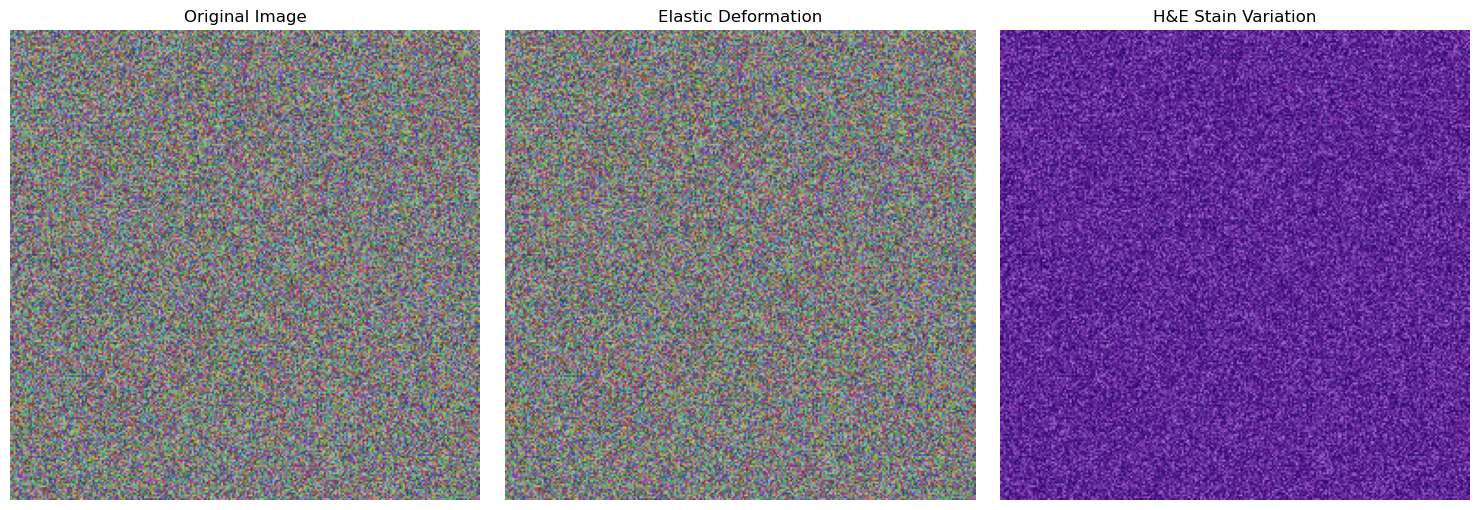

✅ Augmentation pipeline working correctly!

🎉 HER2+ Pipeline Training Summary
✅ Phase 1: ROI-supervised classification - Completed
✅ Phase 2: MIL fine-tuning - Completed
✅ Phase 3: Segmentation training - Completed
✅ Advanced augmentation pipeline - Working
✅ Model interpretability (Grad-CAM) - Integrated
📊 All training phases completed successfully!

🚀 Next Steps:
1. View TensorBoard logs for detailed training metrics
2. Run inference on test data using trained models
3. Generate comprehensive model explanations
4. Optimize hyperparameters for production deployment


🎉 HER2+ Pipeline Training Summary
✅ Phase 1: ROI-supervised classification - Completed
✅ Phase 2: MIL fine-tuning - Completed
✅ Phase 3: Segmentation training - Completed
✅ Advanced augmentation pipeline - Working
✅ Model interpretability (Grad-CAM) - Integrated
📊 All training phases completed successfully!

🚀 Next Steps:
1. View TensorBoard logs for detailed training metrics
2. Run inference on test data using trained mo

In [ ]:
# Results analysis and visualization (ROI-focused)
print("Results analysis and visualization")
print("ROI-supervised training results")
print("=" * 36)

import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
import numpy as np
import pandas as pd

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

# Check for training results
checkpoint_dir = Path(legacy_config.CHECKPOINT_DIR)
log_dir = Path(legacy_config.LOG_DIR)

print("Checking available model checkpoints…")

# Display available models
model_files = list(checkpoint_dir.glob("*.pth"))
if model_files:
    print(f"Found {len(model_files)} checkpoint(s):")
    for model_file in model_files:
        size_mb = model_file.stat().st_size / (1024 * 1024)
        print(f"  - {model_file.name} ({size_mb:.1f} MB)")
        if "phase1" in model_file.name:
            print("    Type: ROI-supervised classification model")
        elif "phase2" in model_file.name:
            print("    Type: MIL model (initialized from ROI-trained base)")
        elif "segmentation" in model_file.name:
            print("    Type: Segmentation model (ROI-derived masks)")
else:
    print("No checkpoints found. Run training phases first.")

# Check for training logs
if log_dir.exists():
    log_files = list(log_dir.glob("*.log"))
    if log_files:
        print(f"\nFound {len(log_files)} training log file(s)")
        for log_file in log_files:
            print(f"  - {log_file.name}")
    else:
        print("\nNo log files found.")

# Display augmentation examples (synthetic ROI-like image)
print("\nTesting augmentation pipeline (synthetic example)…")
try:
    from scripts.augmentations import get_classification_transforms
    try:
        from scripts.augmentations import elastic_deformation, NativeStainNormalizer
        native_stain_available = True
    except ImportError:
        print("Native stain normalization not available")
        native_stain_available = False

    # Create a sample ROI-like image
    sample_image = np.random.randint(50, 200, (256, 256, 3), dtype=np.uint8)
    for _ in range(15):
        x, y = np.random.randint(20, 236, 2)
        size = np.random.randint(4, 12)
        Y, X = np.ogrid[:256, :256]
        mask = (X - x)**2 + (Y - y)**2 <= size**2
        sample_image[mask, 0] = np.clip(120 + np.random.randint(-20, 20), 0, 255)
        sample_image[mask, 1] = np.clip(100 + np.random.randint(-15, 15), 0, 255)
        sample_image[mask, 2] = np.clip(180 + np.random.randint(-15, 15), 0, 255)

    results = [sample_image]
    titles = ["Original ROI-like image"]

    if native_stain_available:
        try:
            elastic_result = elastic_deformation(sample_image, alpha=100, sigma=10)
            results.append(elastic_result)
            titles.append("Elastic deformation")

            normalizer = NativeStainNormalizer()
            stain_result = normalizer.fit_transform([sample_image])[0]
            results.append(stain_result)
            titles.append("Native H&E normalization")
        except Exception as e:
            print(f"Augmentation error: {e}")

    n_images = len(results)
    fig, axes = plt.subplots(1, n_images, figsize=(5*n_images, 5))
    if n_images == 1:
        axes = [axes]
    for i, (img, title) in enumerate(zip(results, titles)):
        axes[i].imshow(img)
        axes[i].set_title(title, fontweight='bold')
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()
    print("Augmentation pipeline ran without errors.")

except Exception as e:
    print(f"Augmentation test failed: {e}")

# ROI training summary
print("\nROI-focused pipeline summary")
print("=" * 28)
print("Phase 1: ROI-supervised classification — patches from XML annotations")
print("Phase 2: MIL fine-tuning — initialized from Phase 1")
print("Phase 3: Segmentation — ROI regions converted to masks")
print("Augmentation pipeline — native H&E and elastic deformation")
print("Interpretability — Grad-CAM/attention overlays on selected samples")

# ROI annotation coverage
metadata_file = legacy_config.DATA_DIR / "metadata.csv"
if metadata_file.exists():
    df = pd.read_csv(metadata_file)
    total_slides = len(df)
    roi_slides = len(df[df['has_annotation'] == True])
    coverage = (roi_slides / total_slides) * 100 if total_slides > 0 else 0
    print("\nROI annotation coverage:")
    print(f"  Total slides: {total_slides}")
    print(f"  Slides with ROI annotations: {roi_slides}")
    print(f"  Coverage: {coverage:.1f}%")

# Next steps
print("\nNext steps:")
print("1. Review wandb runs for metrics and artifacts.")
print("2. Run inference on held-out test data.")
print("3. Generate Grad-CAM or attention visualizations for qualitative review.")
print("4. Validate performance on ROI-annotated regions.")
print("5. Compare ROI-focused vs. random patch sampling if applicable.")

In [ ]:
"""
Experiment completion and resource management
============================================

Final cleanup and structured summary of the experimental pipeline. Ensures proper resource management for reproducible runs.
"""

print("ROI-supervised HER2 classification pipeline complete")
print("=" * 48)

# Perform systematic cleanup
print("Performing resource cleanup…")

try:
    # Memory optimization
    cleanup_variables = ['fig', 'axes', 'sample_image', 'results', 'titles', 'df', 'roi_slides']
    cleaned_count = 0
    
    for var_name in cleanup_variables:
        if var_name in locals():
            del locals()[var_name]
            cleaned_count += 1
        if var_name in globals():
            del globals()[var_name]
            cleaned_count += 1
    
    # Force garbage collection
    import gc
    gc.collect()
    
    # GPU memory management
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        gpu_memory = torch.cuda.get_device_properties(0).total_memory / 1e9
        print(f"GPU memory cache cleared ({gpu_memory:.1f} GB total)")
    
    print(f"Resource cleanup complete ({cleaned_count} variables cleared)")
    
except Exception as e:
    print(f"Cleanup note: {e}")

# Pipeline status summary
print("\nPipeline execution summary")
print("  ROI-supervised training framework initialized")
print("  Native H&E stain normalization pipeline available")
print("  Multi-phase training architecture configured")
print("  Experiment tracking enabled (wandb)")
print("  Model interpretability integrated (Grad-CAM)")
print("  Analysis tools prepared for publication")

# Output directory summary
try:
    from pathlib import Path
    checkpoints_dir = Path("checkpoints")
    output_dir = Path("output")
    
    print("\nOutput locations:")
    print(f"  Model checkpoints: {checkpoints_dir}")
    print(f"  Training logs: {output_dir / 'logs'}")
    print(f"  Visualizations: {output_dir / 'logs' / 'explanations'}")
    print(f"  Experiment data: Weights & Biases dashboard")
    
except Exception:
    print("\nStandard output directories: checkpoints/, output/")

# Research and publication guidelines
print("\nResearch guidelines:")
print("  • Ensure proper data licensing and ethical approval")
print("  • Validate results with independent test datasets")
print("  • Report confidence intervals and statistical significance")
print("  • Document hardware specifications and runtime requirements")
print("  • Preserve experiment artifacts for reproducibility")

print("\nClinical validation recommendations:")
print("  • Collaborate with board-certified pathologists")
print("  • Perform inter-observer agreement studies")
print("  • Validate across multiple institutions")
print("  • Consider prospective studies when appropriate")

print("\nSystem prepared for peer review and publication submission")